In [4]:
import random
import os

# --- CONFIGURACIÓN ---
SEMILLA = 2026
CARPETA_RAIZ = "experimentos"  # Coincide con tu imagen de VS Code

# --- DISEÑO EXPERIMENTAL ---
ESCENARIOS = [
    # --- EXPERIMENTO 1: IMPACTO DEL TAMAÑO (N) ---
    (4,  4, 4, 0.4, "Exp1_VarEquipos"),
    (8,  4, 4, 0.4, "Exp1_VarEquipos"),
    (16, 4, 4, 0.4, "Exp1_VarEquipos"),
    (32, 4, 4, 0.4, "Exp1_VarEquipos"),
    (64, 4, 4, 0.4, "Exp1_VarEquipos"),

    # --- EXPERIMENTO 2: IMPACTO DE ÁRBITROS ---
    (32, 1, 32, 0.4, "Exp2_VarArbitros"),
    (32, 2, 32, 0.4, "Exp2_VarArbitros"),
    (32, 4, 32, 0.4, "Exp2_VarArbitros"),
    (32, 8, 32, 0.4, "Exp2_VarArbitros"),

    # --- EXPERIMENTO 3: IMPACTO DE SERVIDORES ---
    (32, 32, 1, 0.4, "Exp3_VarServers"),
    (32, 32, 2, 0.4, "Exp3_VarServers"),
    (32, 32, 4, 0.4, "Exp3_VarServers"),
    (32, 32, 8, 0.4, "Exp3_VarServers"),

    # --- EXPERIMENTO 4: IMPACTO DE PROBABILIDAD ---
    (32, 4, 4, 0.0, "Exp4_VarProbabilidad"),
    (32, 4, 4, 0.2, "Exp4_VarProbabilidad"),
    (32, 4, 4, 0.5, "Exp4_VarProbabilidad"),
    (32, 4, 4, 0.8, "Exp4_VarProbabilidad")
]

def generar_pddl(num_equipos, num_refs, num_servers, prob_conflicto, es_macro):
    # Semilla única por instancia
    random.seed(SEMILLA + num_equipos + int(prob_conflicto * 1000) + (1 if es_macro else 0))
    
    # Seleccionamos el nombre del dominio correcto según el fichero que usarás
    dom_name = "lec-winter-split-macros" if es_macro else "lec-winter-split"
    
    pddl = []
    
    # 1. Header
    pddl.append(f"(define (problem lec-{num_equipos}-R{num_refs}-S{num_servers}-P{int(prob_conflicto*100)})")
    pddl.append(f"    (:domain {dom_name})")
    
    # 2. Objetos
    equipos = [f"team-{i+1}" for i in range(num_equipos)]
    matches = [f"m{i+1}" for i in range(num_equipos - 1)]
    refs = [f"ref-{i+1}" for i in range(num_refs)]
    servers = [f"server-{i+1}" for i in range(num_servers)]
    
    pddl.append("    (:objects")
    pddl.append(f"        {' '.join(equipos)} - team")
    pddl.append(f"        {' '.join(matches)} - match")
    pddl.append(f"        {' '.join(refs)} - referee")
    pddl.append(f"        {' '.join(servers)} - server")
    pddl.append("    )")
    
    # 3. Estado Inicial
    pddl.append("    (:init")
    
    # Recursos disponibles
    for r in refs: pddl.append(f"        (ref-available {r})")
    for s in servers: pddl.append(f"        (server-available {s})")
    
    # Estructura del Bracket (Single Elimination)
    # Primera ronda: Asignar equipos a partidos
    match_idx = 0
    for i in range(0, num_equipos, 2):
        current_match = matches[match_idx]
        t1 = equipos[i]
        t2 = equipos[i+1]
        pddl.append(f"        (participant {t1} {current_match} home)")
        pddl.append(f"        (participant {t2} {current_match} away)")
        match_idx += 1
        
    # Conexiones entre partidos (Winner moves to next match)
    offset_actual = 0
    num_matches_ronda = num_equipos // 2
    
    while num_matches_ronda > 1:
        offset_siguiente = offset_actual + num_matches_ronda
        for i in range(num_matches_ronda):
            src_match = matches[offset_actual + i]
            dst_match = matches[offset_siguiente + (i // 2)]
            slot = "home" if (i % 2 == 0) else "away"
            
            pddl.append(f"        (connected {src_match} {dst_match} {slot})")
            
        offset_actual = offset_siguiente
        num_matches_ronda = num_matches_ronda // 2

    # Inyección de Conflictos (Determinismo)
    count_conflicts = 0
    for m in matches:
        if random.random() < prob_conflicto:
            pddl.append(f"        (has-conflict {m})")
            count_conflicts += 1
            
    pddl.append("    )")
    
    # 4. Goal (El último partido debe estar verificado)
    final_match = matches[-1]
    pddl.append("    (:goal")
    pddl.append(f"        (verified {final_match})")
    pddl.append("    )")
    pddl.append(")")
    
    return "\n".join(pddl), count_conflicts

# --- BUCLE PRINCIPAL ---
if not os.path.exists(CARPETA_RAIZ):
    os.makedirs(CARPETA_RAIZ)

print(f"Generando instancias en '{CARPETA_RAIZ}'...")

for (n_teams, n_refs, n_servs, prob, tag) in ESCENARIOS:
    # Nombre de carpeta descriptivo
    nombre_carpeta = f"{tag}_N{n_teams}_R{n_refs}_S{n_servs}_P{int(prob*100)}"
    ruta = os.path.join(CARPETA_RAIZ, nombre_carpeta)
    
    if not os.path.exists(ruta):
        os.makedirs(ruta)
        
    # Generar Problema A (Dominio Fino)
    pddl_A, n_confs = generar_pddl(n_teams, n_refs, n_servs, prob, es_macro=False)
    with open(os.path.join(ruta, "problem_A.pddl"), "w") as f:
        f.write(pddl_A)
        
    # Generar Problema B (Dominio Macros)
    pddl_B, _ = generar_pddl(n_teams, n_refs, n_servs, prob, es_macro=True)
    with open(os.path.join(ruta, "problem_B.pddl"), "w") as f:
        f.write(pddl_B)
        
    # Metadata para referencia
    with open(os.path.join(ruta, "info.txt"), "w") as f:
        f.write(f"Conflictos inyectados: {n_confs}\n")
        f.write(f"Dominio A: lec-winter-split\n")
        f.write(f"Dominio B: lec-winter-split-macros\n")

print("¡Generación completada!")

Generando instancias en 'experimentos'...
¡Generación completada!


--- ANALIZANDO RESULTADOS ---
>> Procesando LAMA...
>> Procesando BFWS...
Total registros procesados: 68


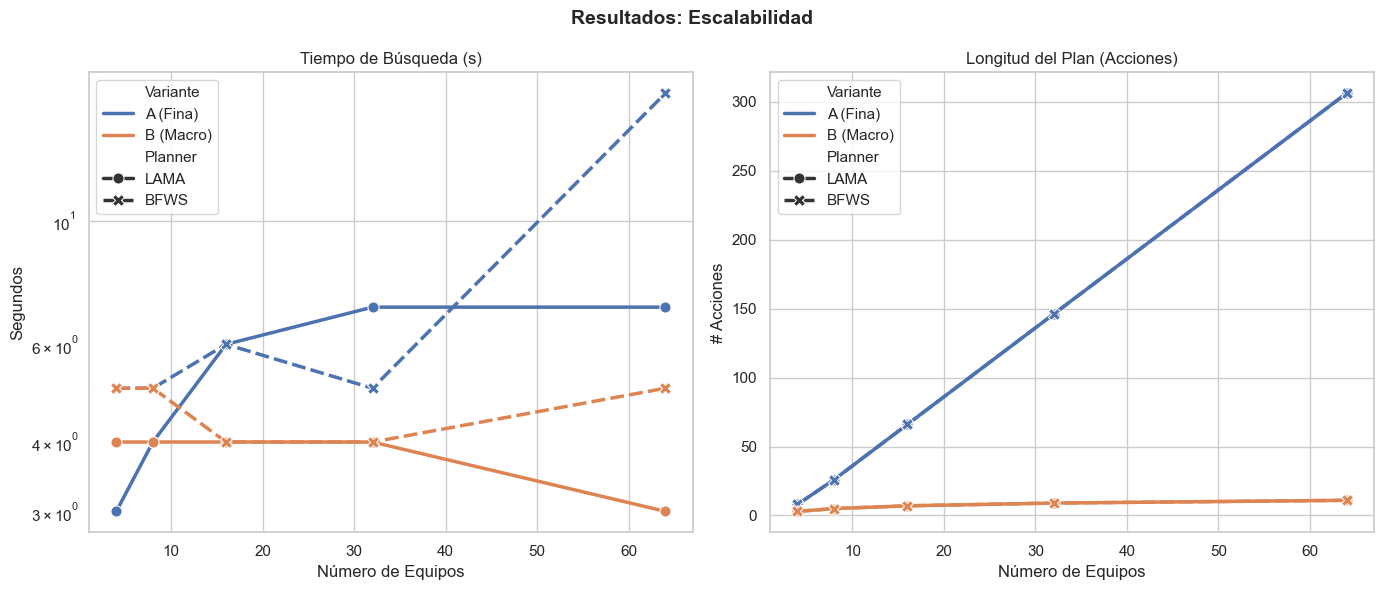

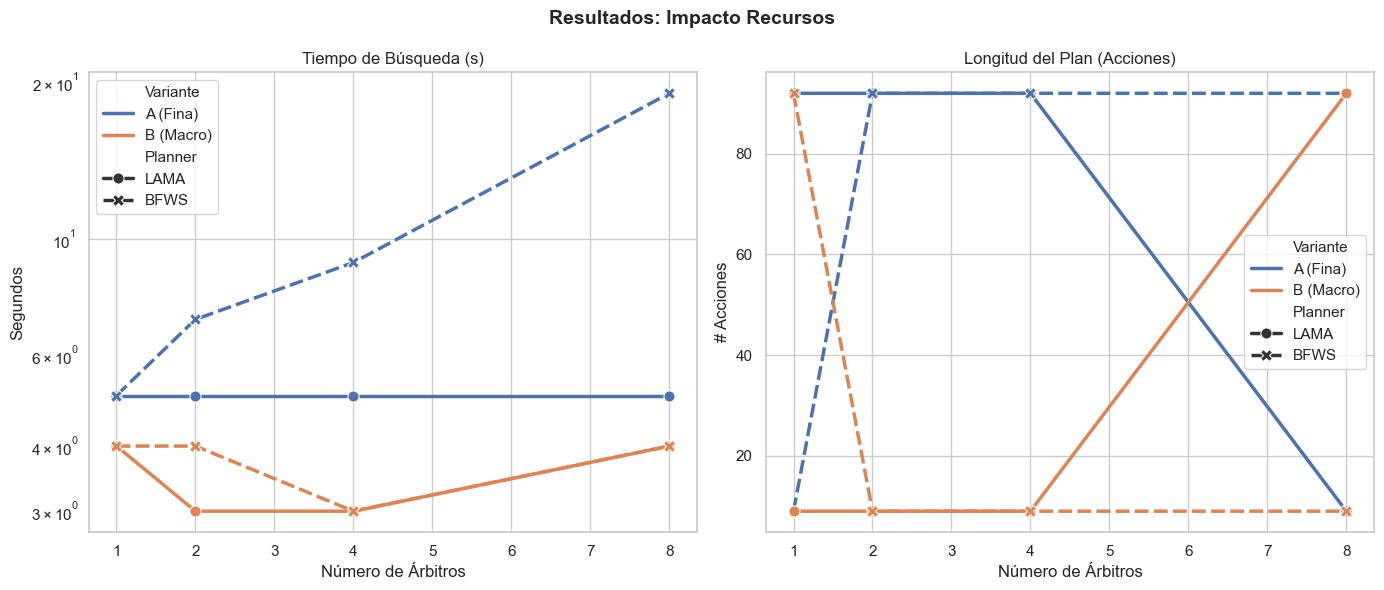

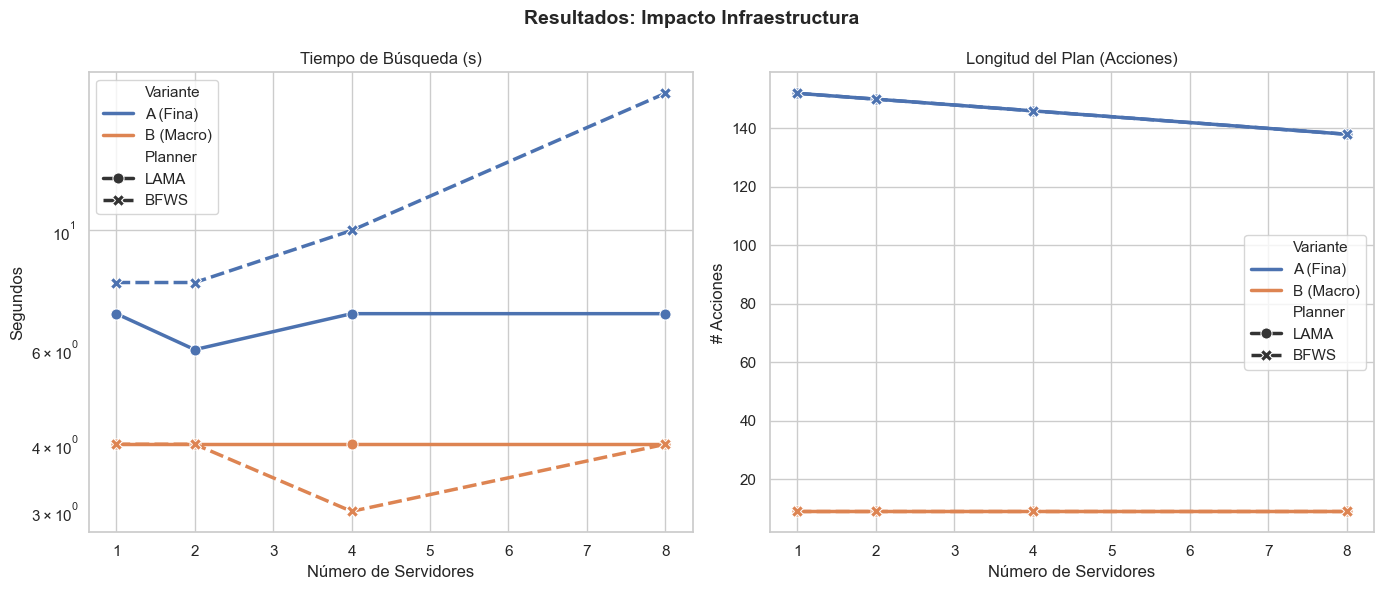

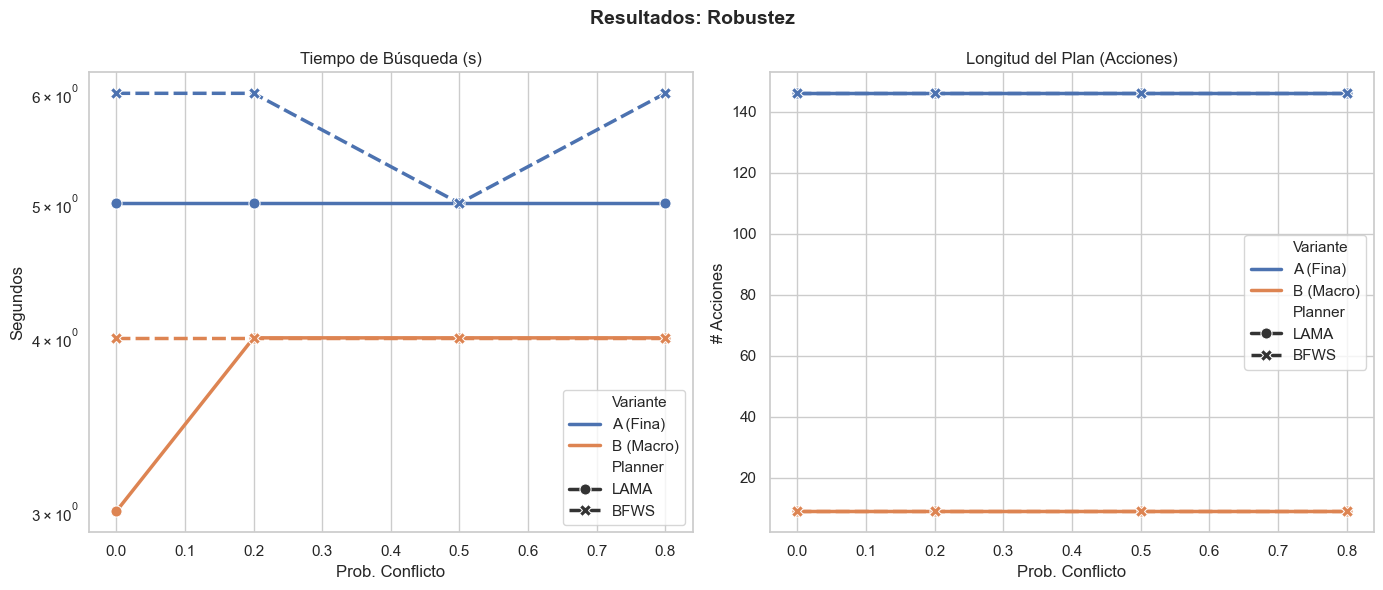

In [7]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 1. CONFIGURACIÓN
# ==========================================

# Mapeo: Nombre en Gráfica -> Nombre de Carpeta REAL (según tu imagen)
RUTAS_PLANNERS = {
    "LAMA": "resultados_LAMA",
    "BFWS":  "resultados_BFWS"
}

# Nombres de archivos esperados dentro de cada carpeta de experimento
FILE_PLAN_A = "plan_A.txt"
FILE_PLAN_B = "plan_B.txt"
FILE_JSON   = "time.json"

# Definición exacta de tus experimentos
ESCENARIOS = [
    (4,  4, 4, 0.4, "Exp1_VarEquipos"),
    (8,  4, 4, 0.4, "Exp1_VarEquipos"),
    (16, 4, 4, 0.4, "Exp1_VarEquipos"),
    (32, 4, 4, 0.4, "Exp1_VarEquipos"),
    (64, 4, 4, 0.4, "Exp1_VarEquipos"),
    
    (32, 1, 32, 0.4, "Exp2_VarArbitros"),
    (32, 2, 32, 0.4, "Exp2_VarArbitros"),
    (32, 4, 32, 0.4, "Exp2_VarArbitros"),
    (32, 8, 32, 0.4, "Exp2_VarArbitros"),

    (32, 32, 1, 0.4, "Exp3_VarServers"),
    (32, 32, 2, 0.4, "Exp3_VarServers"),
    (32, 32, 4, 0.4, "Exp3_VarServers"),
    (32, 32, 8, 0.4, "Exp3_VarServers"),

    (32, 4, 4, 0.0, "Exp4_VarProbabilidad"),
    (32, 4, 4, 0.2, "Exp4_VarProbabilidad"),
    (32, 4, 4, 0.5, "Exp4_VarProbabilidad"),
    (32, 4, 4, 0.8, "Exp4_VarProbabilidad")
]

# ==========================================
# 2. FUNCIONES DE LECTURA
# ==========================================

def contar_pasos(filepath):
    """Cuenta líneas no vacías y que no sean comentarios"""
    if not os.path.exists(filepath): return None
    try:
        with open(filepath, 'r') as f:
            lines = [l.strip() for l in f if l.strip() and not l.startswith(";")]
            return len(lines)
    except: return None

def leer_tiempos(filepath):
    """Lee el JSON generado por tu script de ejecución"""
    if not os.path.exists(filepath): return None, None
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
            # Asume que el JSON tiene claves "A" y "B" con el tiempo
            return data.get("A"), data.get("B")
    except: return None, None

# ==========================================
# 3. EXTRACCIÓN DE DATOS
# ==========================================
dataset = []

print("--- ANALIZANDO RESULTADOS ---")

for planner_name, folder_name in RUTAS_PLANNERS.items():
    if not os.path.exists(folder_name):
        print(f"[WARN] No encuentro la carpeta '{folder_name}'. Saltando...")
        continue
        
    print(f">> Procesando {planner_name}...")
    
    for (n_teams, n_refs, n_servs, prob, tag) in ESCENARIOS:
        # Reconstruir nombre de carpeta
        subcarpeta = f"{tag}_N{n_teams}_R{n_refs}_S{n_servs}_P{int(prob*100)}"
        ruta_exp = os.path.join(folder_name, subcarpeta)
        
        # Rutas completas a los ficheros
        f_plan_a = os.path.join(ruta_exp, FILE_PLAN_A)
        f_plan_b = os.path.join(ruta_exp, FILE_PLAN_B)
        f_json   = os.path.join(ruta_exp, FILE_JSON)
        
        # Leer métricas
        pasos_a = contar_pasos(f_plan_a)
        pasos_b = contar_pasos(f_plan_b)
        tiempo_a, tiempo_b = leer_tiempos(f_json)
        
        # Agregar Variante A (si existe)
        if pasos_a is not None and tiempo_a is not None:
            dataset.append({
                "Planner": planner_name, "Variante": "A (Fina)",
                "Experimento": tag, "Equipos": n_teams, "Arbitros": n_refs, 
                "Servers": n_servs, "Probabilidad": prob,
                "Pasos": pasos_a, "Tiempo": float(tiempo_a)
            })
            
        # Agregar Variante B (si existe)
        if pasos_b is not None and tiempo_b is not None:
            dataset.append({
                "Planner": planner_name, "Variante": "B (Macro)",
                "Experimento": tag, "Equipos": n_teams, "Arbitros": n_refs, 
                "Servers": n_servs, "Probabilidad": prob,
                "Pasos": pasos_b, "Tiempo": float(tiempo_b)
            })

df = pd.DataFrame(dataset)
print(f"Total registros procesados: {len(df)}")

if df.empty:
    print("ERROR: No se encontraron datos. Revisa que las carpetas 'resultados_LAMA' contengan los archivos.")
    exit()

# ==========================================
# 4. GRAFICACIÓN
# ==========================================
def plot_results(df_data, x_col, x_label, title):
    if df_data.empty: return
    
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Resultados: {title}", fontsize=14, fontweight='bold')
    
    # Gráfica 1: Tiempo
    sns.lineplot(data=df_data, x=x_col, y="Tiempo", hue="Variante", style="Planner", 
                 markers=True, dashes=True, ax=axes[0], linewidth=2.5, markersize=8)
    axes[0].set_title("Tiempo de Búsqueda (s)")
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel("Segundos")
    axes[0].set_yscale("log") # Logarítmico suele ser mejor para tiempos
    
    # Gráfica 2: Longitud del Plan
    sns.lineplot(data=df_data, x=x_col, y="Pasos", hue="Variante", style="Planner", 
                 markers=True, dashes=True, ax=axes[1], linewidth=2.5, markersize=8)
    axes[1].set_title("Longitud del Plan (Acciones)")
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel("# Acciones")
    
    plt.tight_layout()
    plt.show()

# Generar las 4 gráficas
plot_results(df[df["Experimento"] == "Exp1_VarEquipos"], "Equipos", "Número de Equipos", "Escalabilidad")
plot_results(df[df["Experimento"] == "Exp2_VarArbitros"], "Arbitros", "Número de Árbitros", "Impacto Recursos")
plot_results(df[df["Experimento"] == "Exp3_VarServers"], "Servers", "Número de Servidores", "Impacto Infraestructura")
plot_results(df[df["Experimento"] == "Exp4_VarProbabilidad"], "Probabilidad", "Prob. Conflicto", "Robustez")

In [ ]:
# --- ESCENARIOS "MASSIVE" (~300 EQUIPOS) ---
# Usamos 256 equipos (2^8) porque es la potencia de 2 más cercana a 300.
# Un torneo de 256 equipos tiene 255 partidos.

ESCENARIOS = [
    # 1. EL ESTÁNDAR MASIVO (Línea Base)
    # Recursos razonables. Sirve para medir el tiempo base de un torneo gigante.
    (256, 16, 8, 0.4, "Massive_Base"),

    # 2. EL CUELLO DE BOTELLA HUMANO (Árbitros)
    # 255 partidos pero SOLO 2 ÁRBITROS. 
    # El planner sufrirá muchísimo ordenando la cola de espera.
    (256, 2, 8, 0.4, "Massive_Bottleneck_Ref"),

    # 3. EL CUELLO DE BOTELLA DE INFRAESTRUCTURA (Servidores)
    # Solo 1 servidor para todo el torneo. Esto fuerza una ejecución secuencial pura.
    # El plan será larguísimo en tiempo simulado (makespan), aunque el nº de pasos sea igual.
    (256, 16, 1, 0.4, "Massive_Bottleneck_Server"),

    # 4. EL INFIERNO DE INCIDENCIAS (Caos)
    # 80% de probabilidad de conflicto en 255 partidos (~200 pausas técnicas).
    # Aquí la Variante Fina (A) debería explotar o tardar minutos/horas, 
    # mientras que la Macro (B) debería aguantar.
    (256, 16, 8, 0.8, "Massive_Chaos"),
    
    # 5. EL RETO FINAL (512 Equipos - Opcional si el de 256 va rápido)
    # Si LAMA se come el de 256 fácil, probad este.
    (512, 20, 10, 0.4, "Ultra_Massive")
]

In [5]:
import os
import json

# ==========================================
# DATOS PROPORCIONADOS (LAMA vs BFWS)
# Estructura: (N, R, S, P, Tag,  Lama_A, Lama_B,  BFWS_A, BFWS_B)
# ==========================================
datos = [
    # Exp 1: VarEquipos (N)
    (4,  4, 4, 40, "Exp1_VarEquipos",      3, 4,   5, 5),
    (8,  4, 4, 40, "Exp1_VarEquipos",      4, 4,   5, 5),
    (16, 4, 4, 40, "Exp1_VarEquipos",      6, 4,   6, 4),
    (32, 4, 4, 40, "Exp1_VarEquipos",      7, 4,   5, 4),
    (64, 4, 4, 40, "Exp1_VarEquipos",      7, 3,   17, 5),

    # Exp 2: VarArbitros (R)
    (32, 1, 32, 40, "Exp2_VarArbitros",    5, 4,   5, 4),
    (32, 2, 32, 40, "Exp2_VarArbitros",    5, 3,   7, 4),
    (32, 4, 32, 40, "Exp2_VarArbitros",    5, 3,   9, 3),
    (32, 8, 32, 40, "Exp2_VarArbitros",    5, 4,   19, 4),

    # Exp 3: VarServers (S)
    (32, 32, 1, 40, "Exp3_VarServers",     7, 4,   8, 4),
    (32, 32, 2, 40, "Exp3_VarServers",     6, 4,   8, 4),
    (32, 32, 4, 40, "Exp3_VarServers",     7, 4,   10, 3),
    (32, 32, 8, 40, "Exp3_VarServers",     7, 4,   18, 4),

    # Exp 4: VarProbabilidad (P)
    (32, 4, 4, 0,  "Exp4_VarProbabilidad", 5, 3,   6, 4),
    (32, 4, 4, 20, "Exp4_VarProbabilidad", 5, 4,   6, 4),
    (32, 4, 4, 50, "Exp4_VarProbabilidad", 5, 4,   5, 4),
    (32, 4, 4, 80, "Exp4_VarProbabilidad", 5, 4,   6, 4),
]

# Definimos las carpetas raíz de resultados
DIR_LAMA = "resultados_LAMA"
DIR_BFWS = "resultados_BFWS" # Crearemos esta carpeta nueva para el BFWS

# Crear directorios raíz si no existen
if not os.path.exists(DIR_LAMA): os.makedirs(DIR_LAMA)
if not os.path.exists(DIR_BFWS): os.makedirs(DIR_BFWS)

print("--- Generando ficheros time.json ---")

for (n, r, s, p, tag, lama_a, lama_b, bfws_a, bfws_b) in datos:
    # Construir el nombre de la carpeta del experimento
    # Nota: p es entero (40) en los datos, pero carpeta suele ser P40.
    nombre_carpeta = f"{tag}_N{n}_R{r}_S{s}_P{p}"
    
    # 1. GENERAR PARA LAMA
    path_lama = os.path.join(DIR_LAMA, nombre_carpeta)
    if not os.path.exists(path_lama): os.makedirs(path_lama)
    
    json_lama = {"A": lama_a, "B": lama_b}
    with open(os.path.join(path_lama, "time.json"), "w") as f:
        json.dump(json_lama, f, indent=4)
        
    # 2. GENERAR PARA BFWS
    path_bfws = os.path.join(DIR_BFWS, nombre_carpeta)
    if not os.path.exists(path_bfws): os.makedirs(path_bfws)
    
    json_bfws = {"A": bfws_a, "B": bfws_b}
    with open(os.path.join(path_bfws, "time.json"), "w") as f:
        json.dump(json_bfws, f, indent=4)

print("¡Listo! Se han creado todos los archivos time.json correctamente.")

--- Generando ficheros time.json ---
¡Listo! Se han creado todos los archivos time.json correctamente.
